<a href="https://colab.research.google.com/github/ColinSullivan9/test/blob/main/MidtermProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing all of our environments

!pip install uszipcode
!pip install plotnine

import plotnine as p9
from plotnine import *
from plotnine.data import *

import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from geopy.geocoders import Nominatim
from uszipcode import SearchEngine
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import pearsonr
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import kruskal

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
## Format column headers
df = pd.read_csv('/content/311_Service_Requests_from_2010_to_Present.csv')
df.columns = df.columns.str.replace(' ', '_')

In [ ]:
## Check missing counts for each row
missing_counts = df.isnull().sum()
print(missing_counts)

Unique_Key                            0
Created_Date                          0
Closed_Date                        4791
Agency                                0
Agency_Name                           0
Complaint_Type                        0
Descriptor                          888
Location_Type                      7396
Incident_Zip                        749
Incident_Address                   2584
Street_Name                        2584
Cross_Street_1                    19485
Cross_Street_2                    19485
Intersection_Street_1             21788
Intersection_Street_2             21748
Address_Type                        412
City                               2373
Landmark                          25682
Facility_Type                     54185
Status                                0
Due_Date                          54365
Resolution_Description             1674
Resolution_Action_Updated_Date     1629
Community_Board                       0
BBL                                6223


In [ ]:
# Used this to create new columns, "start_time" and "close_time", which is formatted in the pd.datetime manner
## Then checked to find rows where the close_time was after the start_time and removed those rows, as that is invalid
## Could not run it in here again because does not work with the updated dataset after I saved the changes to the csv

df['Created_Date'] = pd.to_datetime(df['Created_Date'], format='%m/%d/%Y %I:%M:%S %p')
# 
# 
df['start_time'] = pd.to_datetime(df['Created_Date'], "%m/%d/%Y %I:%M:%S %p")
# 
mask = df['Closed_Date'].notnull()
# 
mask_df = df[mask]
# 
mask_df['Closed_Date'] = pd.to_datetime(df['Closed_Date'], format='%m/%d/%Y %I:%M:%S %p')
df['close_time'] = pd.to_datetime(mask_df['Closed_Date'], "%m/%d/%Y %I:%M:%S %p")
# # print(df['start_time'])
# # print(df['close_time'])
backwards_times = df[df['start_time'] > df['close_time']]
print(backwards_times)
# 
df = df[df['start_time'] <= df['close_time']]

       Unique_Key        Created_Date             Closed_Date Agency  \
15760    56545596 2023-01-17 09:13:00  01/16/2023 09:12:00 AM    DOT   
16345    56548261 2023-01-17 10:14:00  01/16/2023 09:37:00 AM    DOT   
16375    56546592 2023-01-17 10:16:00  01/16/2023 10:15:00 AM    DOT   
16393    56552546 2023-01-17 10:18:00  01/16/2023 10:17:00 AM    DOT   
16544    56549764 2023-01-17 10:28:00  01/16/2023 10:27:00 AM    DOT   
...           ...                 ...                     ...    ...   
43080    56580263 2023-01-20 12:02:00  01/19/2023 11:59:00 AM    DOT   
43082    56582588 2023-01-20 12:03:00  01/19/2023 12:02:00 PM    DOT   
43420    56577266 2023-01-20 12:47:00  01/19/2023 12:42:00 PM    DOT   
44104    56579036 2023-01-20 14:18:00  01/13/2023 02:18:00 PM    DOT   
44523    56579926 2023-01-20 15:02:42  01/12/2023 12:00:00 AM   DSNY   

                        Agency_Name          Complaint_Type  \
15760  Department of Transportation  Street Light Condition   
16345  De

<ipython-input-5-e998716b685b>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
## Checked to find rows where one or both of the longitude and latitude were missing, but the zip was not, and then
## reverse geocoded in the missing values

mask2 = (df['Incident_Zip'].notnull()) & (df['Latitude'].isnull() | df['Longitude'].isnull())
missing_locs = df.loc[mask2]

# print(len(missing_locs))
if len(missing_locs) > 0:
    # Use the uszipcode package to geocode the missing addresses

#     search = SearchEngine()# simple_zipcode=True
    geoloc = Nominatim(user_agent="my_request")
    for index, row in missing_locs.iterrows():
        address = str(row['Street_Name']) + ', ' + str(row['Borough']) + ', New York, NY'
#         zipcode = search.by_zipcode(row['ZIP_CODE'])
        location = geoloc.geocode(row['Incident_Zip'])
#         print(location)
        if location is not None:
            df.at[index, 'Latitude'] = location.latitude
            df.at[index, 'Longitude'] = location.longitude
            print('success')
            print(location.latitude)
        else:
            print('Could not geocode address:', address)

success
25.0353527
success
11.97475
success
11.97475
success
11.97475
success
25.0353527
success
49.7210559
success
49.7210559
success
49.7210559
success
49.7210559
success
49.7210559
success
49.7210559
success
49.7210559
success
49.7210559
success
49.7210559
success
49.7210559
success
49.7210559
success
49.7210559
success
49.7210559
success
9.6116087
success
9.6116087
success
9.6116087
success
9.6116087
success
9.6116087
success
9.8933466
success
9.6116087
success
25.0353527
success
25.0353527
success
25.0353527
success
9.6116087
success
49.7599448
success
9.6116087
success
9.6116087
success
25.0353527
success
49.7599448
success
25.0353527
success
49.7106126
success
49.7106126
success
9.6116087
success
49.686919
success
9.6116087
success
49.7663154
success
47.5241667
success
49.8495857
success
49.8495857
success
49.8495857
success
49.8495857
success
49.8495857
success
49.8495857
success
49.8495857
success
49.8495857
success
49.8495857
success
49.8495857
success
49.7454767
success
9.61

In [ ]:
## Similarly, found where longitude and latitude were available but zip code was not, and reverse geocoded it in using geopy

subset = df[(df['Incident_Zip'].isna()) & (~df['Latitude'].isna()) & (~df['Longitude'].isna())]
n = len(subset)
# print(n)
if n > 0:
    # Use the uszipcode package to geocode the missing addresses

#     search = SearchEngine()# simple_zipcode=True
    geoloc = Nominatim(user_agent="my_request")
    for index, row in subset.iterrows():
#         zipcode = search.by_zipcode(row['ZIP_CODE'])
        location = geoloc.reverse((row['Latitude'], row['Longitude']))
#         print(location)
        nzip = int(location.raw['address'].get('postcode'))
        df.loc[subset.index, 'Incident_Zip'] = nzip
        # print(n)
        n -= 1

In [ ]:
## Found rows where the zip, latitude, and longitude were missing but the street name was not, and reverse geocoded in when possible

mask3 = (df['Street_Name'].notnull()) & (df['Incident_Zip'].isnull()) & (df['Latitude'].isnull() | df['Longitude'].isnull())
missing_locs2 = df.loc[mask3]
# print(len(missing_locs2))



if len(missing_locs2) > 32:
    # Use the uszipcode package to geocode the missing addresses

#     search = SearchEngine()# simple_zipcode=True
    geoloc = Nominatim(user_agent="my_request")
    for index, row in missing_locs2.iterrows():
        address = str(row['Street_Name']) + ', ' + str(row['Borough']) + ', New York, NY'
#         zipcode = search.by_zipcode(row['ZIP_CODE'])
        location = geoloc.geocode(address)
#         print(location)
        if location is not None:
            df.at[index, 'Latitude'] = location.latitude
            df.at[index, 'Longitude'] = location.longitude
            loc = location.raw
            loc_data = loc['display_name'].split()
            zip_w_comma = loc_data[-3]
            zipcode =int(zip_w_comma.rstrip(','))
            print(location.latitude)
            print(zipcode)
            df.at[index, 'Incident_Zip'] = zipcode
            print('success')
            df.to_csv('nyc311_011523-012123_by022023.csv', encoding='utf-8', index=False)
        else:
            print('Could not geocode address:', address)


In [ ]:
#Remove Unspecified from the boroughs

df['Borough'].value_counts()
df = df[df['Borough'] != 'Unspecified']

Question 2

In [ ]:
# print(len(df))
df = df[df['Agency']=='NYPD']
# print(len(df))
## Cuts length from 49550 to 21533

## Add duration in minutes
for index, row in df.iterrows():
     df.at[index, 'Duration'] = pd.Timedelta(pd.to_datetime(row['close_time']) - pd.to_datetime(row['start_time'])).seconds / 60
# print(df['Duration'])

df['start_time'] = pd.to_datetime(df['start_time'])
df['Day_of_Week'] = df['start_time'].dt.dayofweek
df['Weekend'] = (df['Day_of_Week'] >= 5).astype(int)
# print(df['Day_of_Week'])

def durations(group):
    return group['Duration'].values

bor_group = df.groupby('Borough')
dur_by_bor = bor_group.apply(durations)

df.count()

Unique_Key                        21405
Created_Date                      21405
Closed_Date                       21405
Agency                            21405
Agency_Name                       21405
Complaint_Type                    21405
Descriptor                        20981
Location_Type                     21405
Incident_Zip                      21393
Incident_Address                  21288
Street_Name                       21288
Cross_Street_1                    21269
Cross_Street_2                    21271
Intersection_Street_1             21269
Intersection_Street_2             21271
Address_Type                      21288
City                              20329
Landmark                          20329
Facility_Type                         0
Status                            21405
Due_Date                              0
Resolution_Description            21405
Resolution_Action_Updated_Date    21405
Community_Board                   21405
BBL                               19519


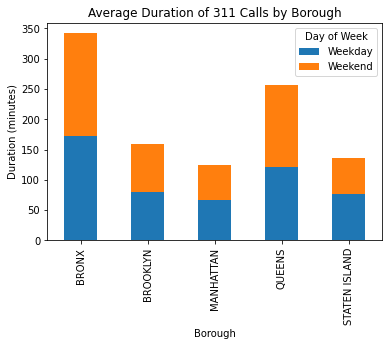

In [ ]:
# # plot the grouped data as a bar chart
group = df.groupby(['Borough', 'Weekend'])
# 
graph = group['Duration'].mean().unstack()
graph.plot(kind='bar', stacked=True)
# 
plt.title('Average Duration of 311 Calls by Borough')
plt.xlabel('Borough')
plt.ylabel('Duration (minutes)')
legend = plt.legend(title='Day of Week')
legend.get_texts()[0].set_text('Weekday')
legend.get_texts()[1].set_text('Weekend')
# 
# # Show plot
plt.show()

[Text(0.5, 1.0, 'Scatterplot of Duration by Day of Week')]

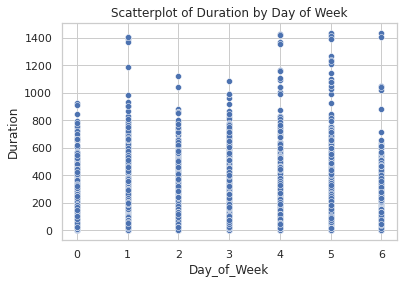

In [ ]:
# Distribution of duration of response time by day of week 
sns.set(style='whitegrid')
 
sns.scatterplot(x="Day_of_Week",
                    y="Duration",
                    data=df).set(title='Scatterplot of Duration by Day of Week')

[Text(0.5, 1.0, 'Boxplot of Duration by Borough Filtered by Weekend')]

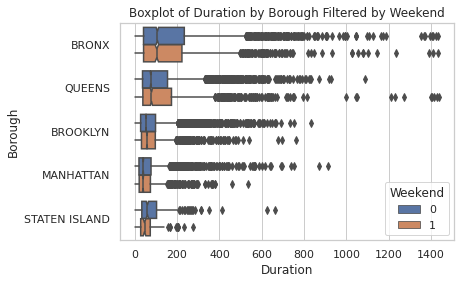

In [ ]:
#Boxplot of distribution of duration by borough and day of week

sns.boxplot(data=df, x="Duration", y="Borough", hue="Weekend", 
    notch=True, showcaps=False,
    ).set(title='Boxplot of Duration by Borough Filtered by Weekend')

<ipython-input-21-f17c01134077>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-21-f17c01134077>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.8/dist-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 11 rows containing missing values.


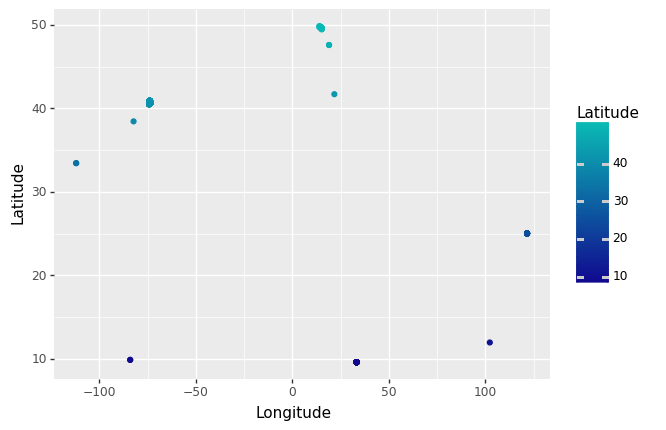

<ggplot: (8777462292333)>

In [ ]:
#Plot of latitude and longitude in cleaned data

df2 = df.head(20000)
df2["Latitude"] = df2["Latitude"].replace([0.0], np.nan)
df2["Longitude"] = df2["Longitude"].replace([0.0], np.nan)

(
    ggplot(df2, # The dataset we are using
        aes(x = 'Longitude', y='Latitude', color = 'Latitude')) # We have our x as Longitude, y as latitude, and we colored the clusters by its latitude
        + geom_point()
        + scale_color_gradient(low='#10098f', high='#0ABAB5',guide='colorbar')
        # From low lattitude to high lattitude colors -- according to colorbar(p.s. Ultramarine and Tiffany blue, my favorites blue colors)         
)

In [ ]:
F, p = stats.f_oneway(dur_by_bor[0], dur_by_bor[1], dur_by_bor[2], dur_by_bor[3], dur_by_bor[4], axis=0)
print("F statistic of ANOVA test is " + str(F))
## F statistic sooo high, there is a difference in duration by borough.

day_group = df.groupby('Weekend')
dur_by_day = day_group.apply(durations)
print(stats.ttest_ind(dur_by_day[0], dur_by_day[1], alternative='two-sided'))
## P value high, there is not a difference

data1 = df['Duration']
data2 = df['Weekend']

# Finding the correlation between duration and weekend
corr, _ = pearsonr(data1, data2)
print('Pearsons correlation: %.3f' % corr)
# correlation almost 0, shows no correlation

F statistic is 501.9913570925773
Ttest_indResult(statistic=-1.685895650508049, pvalue=0.09183047572417903)
Pearsons correlation: 0.012


Question 3

In [ ]:
# Defining relevant features for model
features = df[['Complaint_Type', 'Incident_Zip', 'Borough', 'Descriptor', 'Location_Type', 'City', 'Duration']]

In [ ]:
# Encoding categorical variables
def encode(feature):
    global features
    uniques = feature.unique()
    encode_dict = {}
    for index, factor in enumerate(uniques):
        encode_dict[factor] = index
    
    features = features.replace(encode_dict)

encode(features['Complaint_Type'])
encode(features['Borough'])
encode(features['Descriptor'])
encode(features['Location_Type'])
encode(features['City'])

In [ ]:
# Scaling variables
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features.iloc[:, :-1] = scaler.fit_transform(features.iloc[:, :-1])

In [ ]:
# Creating x and y features and binning y values into 0-3 hours and 3+ hours
x = features.iloc[:, :-1]
y = pd.cut(features['Duration'], bins = (0, 180, 9999), labels = ('0-3 Hours', '3+ Hours'))


X_train, X_test, y_train, y_test  = train_test_split(x, y, test_size = 0.25)

In [ ]:
# Checking which model will work best for this exercise by cross validating multiple models.
models = []
models.append(("LR", LogisticRegression()))
models.append(("NB", GaussianNB()))
models.append(("RF", RandomForestClassifier()))
models.append(("SVC", SVC()))
models.append(("Dtree", DecisionTreeClassifier()))
models.append(("KNN", KNeighborsClassifier()))

#measure the accuracy 
for name, model in models:
    kfold = KFold(n_splits=3)
    cv_result = cross_val_score(model, X_train, y_train, cv = kfold, scoring = "accuracy")
    print(name, cv_result)

LR [0.83423659 0.83554476 0.83461035]
NB [0.80844702 0.80097178 0.80732573]
RF [0.8125584  0.82208933 0.81965988]
SVC [0.83423659 0.835171   0.83479723]
Dtree [0.81012895 0.81965988 0.81685666]
KNN [0.8155485  0.8164829  0.82582695]


While logistic regression may have had the best accuracy, we choose Random Forest Classification because we are interested in it and have yet to be able to implement one in this class.

In [ ]:
# Checking with parameters yield the best model by cross validating using grid search
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': [10, 15, 20],
              'min_impurity_decrease': [1e-4, 1e-3, 1e-2],
              'ccp_alpha': [0.0, 1e-5, 1e-4, 1e-3],
              }
rf_clf = RandomForestClassifier()
grid_search = GridSearchCV(rf_clf, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'ccp_alpha': 1e-05,
 'criterion': 'entropy',
 'max_depth': 20,
 'min_impurity_decrease': 0.0001}

In [ ]:
# Fitting model with parameters we just got from grid search
rf_clf = RandomForestClassifier(ccp_alpha = 0.0001, criterion = 'entropy', max_depth = 20, min_impurity_decrease = 0.0001, oob_score = True)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(ccp_alpha=0.0001, criterion='entropy', max_depth=20,
                       min_impurity_decrease=0.0001, oob_score=True)

In [ ]:
# Checking model accuracy (oob score)
rf_clf.oob_score_

0.8384725596461721

In [ ]:
# Predicting on test set
y_pred = rf_clf.predict(X_test)

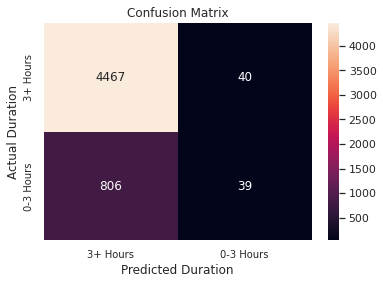

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

import matplotlib.pyplot as plt
import seaborn as sns
ax = plt.subplot()
uniques = list(y_train.unique())
sns.heatmap(cm, annot = True, ax = ax, fmt = 'g')
ax.set_xlabel('Predicted Duration')
ax.set_ylabel('Actual Duration')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(uniques)
ax.yaxis.set_ticklabels(uniques)
ax.xaxis.set_tick_params(labelsize = 'small')
ax.yaxis.set_tick_params(labelsize = 'small')

Question 4

Our research question: Does duration vary by agency?

In [ ]:
dataQ4 = pd.read_csv('/content/311_Service_Requests_from_2010_to_Present.csv')

dataQ4

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location
0,56533302,01/15/2023 12:00:00 AM,01/23/2023 12:00:01 AM,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Other (Explain Below),11101.0,48-18 NORTHERN BOULEVARD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.753619,-73.914245,"(40.75361894380833, -73.91424532268624)"
1,56533451,01/15/2023 12:00:00 AM,01/17/2023 09:34:08 AM,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Food Cart Vendor,10305.0,1941 HYLAN BOULEVARD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.582218,-74.097217,"(40.58221767593629, -74.09721689751461)"
2,56532399,01/15/2023 12:00:00 AM,01/17/2023 12:00:01 AM,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Restaurant/Bar/Deli/Bakery,11101.0,28-07 JACKSON AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.748433,-73.938768,"(40.74843329250923, -73.93876844606294)"
3,56538004,01/15/2023 12:00:00 AM,01/23/2023 03:08:02 PM,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,3 or More,Other (Explain Below),10036.0,700 8 AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.758662,-73.988738,"(40.75866221848322, -73.98873795996684)"
4,56536021,01/15/2023 12:00:00 AM,01/17/2023 09:48:19 AM,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Restaurant/Bar/Deli/Bakery,11103.0,24-11 STEINWAY STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.768674,-73.911074,"(40.76867420855789, -73.91107425623979)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54464,56584502,01/21/2023 11:58:29 PM,01/22/2023 01:34:56 AM,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,11210.0,1411 NEW YORK AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.638251,-73.945305,"(40.63825058438901, -73.945304714947)"
54465,56585461,01/21/2023 11:58:35 PM,01/30/2023 07:26:32 PM,HPD,Department of Housing Preservation and Develop...,WATER LEAK,SLOW LEAK,RESIDENTIAL BUILDING,10467.0,3422 KNOX PLACE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.881825,-73.883602,"(40.88182541778601, -73.88360163299659)"
54466,56588474,01/21/2023 11:58:36 PM,01/22/2023 01:02:17 AM,NYPD,New York City Police Department,Blocked Driveway,No Access,Street/Sidewalk,11207.0,1186 DECATUR STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.688741,-73.907561,"(40.68874136917321, -73.9075605899351)"
54467,56590134,01/21/2023 11:58:43 PM,01/22/2023 01:13:54 AM,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,11237.0,421 STANHOPE STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.705433,-73.915725,"(40.70543308605369, -73.91572476128748)"


In [ ]:
dataQ4

# Creating the duration column for our new dataset
dataQ4['Created Date'] = pd.to_datetime(dataQ4['Created Date'], format='%m/%d/%Y %I:%M:%S %p')
# 
# 
dataQ4['start_time'] = pd.to_datetime(dataQ4['Created Date'], "%m/%d/%Y %I:%M:%S %p")
# 
mask1 = dataQ4['Closed Date'].notnull()
# 
mask_df1 = dataQ4[mask1]
# 
mask_df1['Closed Date'] = pd.to_datetime(dataQ4['Closed Date'], format='%m/%d/%Y %I:%M:%S %p')
dataQ4['close_time'] = pd.to_datetime(mask_df1['Closed Date'], "%m/%d/%Y %I:%M:%S %p")
# # print(df['start_time'])
# # print(df['close_time'])
backwards_times1 = dataQ4[dataQ4['start_time'] > dataQ4['close_time']]
# print(backwards_times)
# 
dataQ4 = dataQ4[dataQ4['start_time'] <= dataQ4['close_time']]

dataQ4['start_time'] = pd.to_datetime(dataQ4['start_time'])
dataQ4['Day_of_Week'] = dataQ4['start_time'].dt.dayofweek
dataQ4['Weekend'] = (dataQ4['Day_of_Week'] >= 5).astype(int)

for index, row in dataQ4.iterrows():
    dataQ4.at[index, 'Duration'] = pd.Timedelta(pd.to_datetime(row['close_time']) - pd.to_datetime(row['start_time'])).seconds / 60

def durations(group):
    return group['Duration'].values

bor_group1 = dataQ4.groupby('Borough')
dur_by_bor1 = bor_group1.apply(durations)

<ipython-input-36-b90b0f25a856>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-36-b90b0f25a856>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-36-b90b0f25a856>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-36-b90b0f25a8

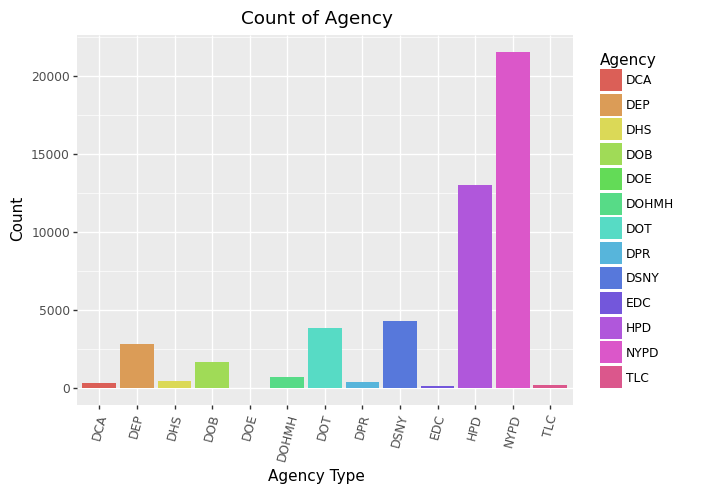

<ggplot: (8777461995030)>

In [ ]:
# Bar chart of the count of each agency represented

(
    ggplot(dataQ4, # The dataset we are using
           aes(x = 'Agency', fill='Agency'))  # x is the specific column in the dataset we are using, 'fill' color the columns of Agency
    + geom_bar() # The plot we want to make
    + theme(axis_text_x=element_text(angle=75)) #We want the text to have an angle
    + ggtitle('Count of Agency') # Make a title for the chart
    + xlab("Agency Type") # Change x lable of the graph
    + ylab("Count")) # Change y lable of the graph
   

/usr/local/lib/python3.8/dist-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 918 rows containing missing values.


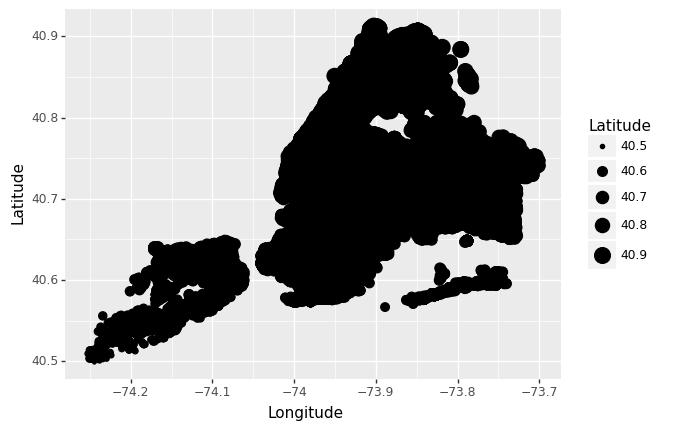

<ggplot: (8777462257137)>

In [ ]:
# Plot of 311 claim distribution by lat and long

(
    ggplot(dataQ4, # The dataset we are using
        aes(x = 'Longitude', y='Latitude', size = 'Latitude')) # Make x and y axis, and make point size by latitude
        + geom_point( # Fill the point inside the graph
        ) 
)

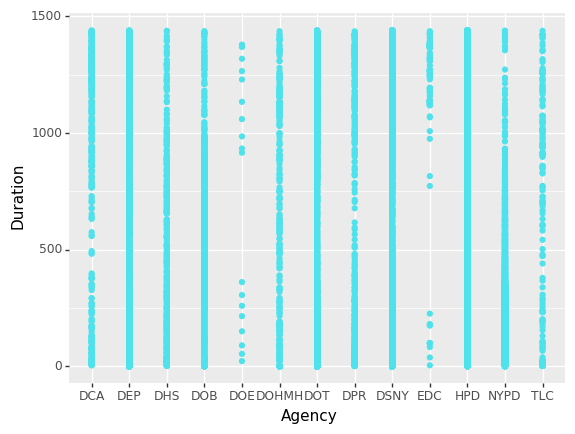

<ggplot: (8777462232652)>

In [ ]:
# Scatterplot of duration of response by agency

(
    ggplot(dataQ4, aes(x = 'Agency', y = 'Duration'))
    + geom_point(color = '#4EE2EC') # Diamond blue!
    + labs(x='Agency', y='Duration')
)

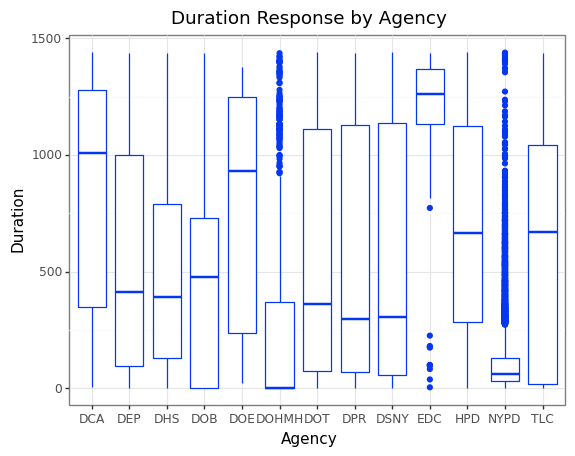

<ggplot: (8777461304043)>

In [ ]:
# Boxplot showing mean response by agency 

(
    ggplot(dataQ4, # The data we are using
             aes("Agency" , "Duration")) 
    + geom_boxplot(color = "#0437F2") # The plot we are using, and change the color in here
    + xlab("Agency") # Change the title of x axis
    + ylab("Duration") # Change the title of y axis
    + ggtitle("Duration Response by Agency") # Add a title for the graph
    + theme_bw()
)

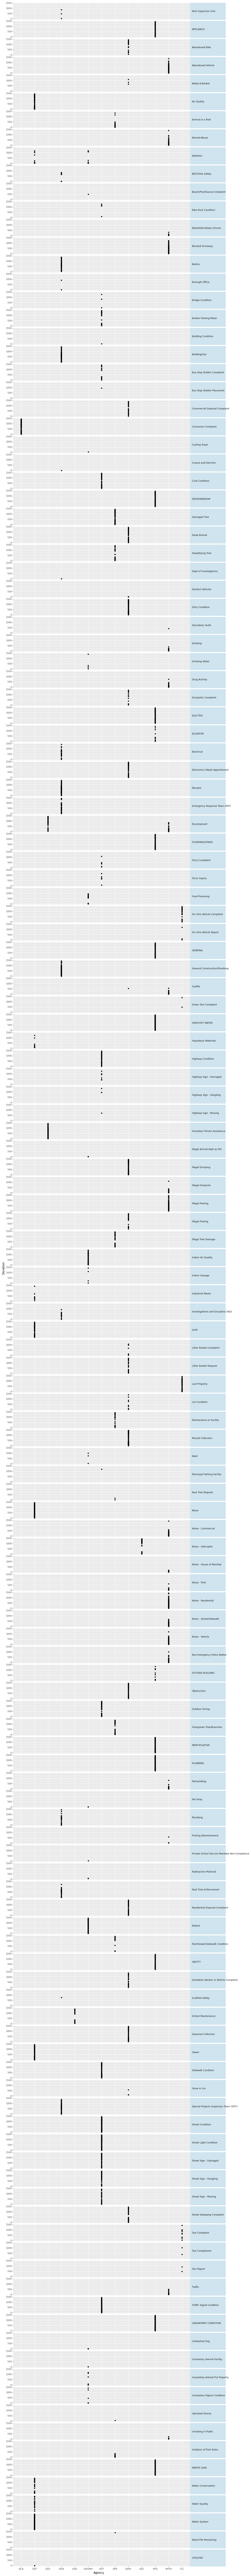

<ggplot: (8777458594542)>

In [ ]:
# Facet grid plotting duration, agency and complaint type to show various distributions and how long a typical response time takes

(
    ggplot(dataQ4, aes(x='Agency', y='Duration')) # The plot we want to make
    + geom_point()
    + facet_grid('Complaint Type ~ .') 
    + theme(strip_text_y = element_text(angle = 0,              # Change facet text angle
                                        ha = 'left'             # Change text alignment
                                       ),
            strip_background_y = element_text(color = '#cfe4ee' # Change background colour of facet background
                                              , width = .2     # Adjust width of facet background to fit facet text
                                             ),
            figure_size=(12,175)                                 # Adjust width & height of figure to fit y-axis
           )
)

We had two different groupmates working on this problem separately so that is why we have two separate datasets, however both contain the same information so it is fine.

In [ ]:
# Select subset of data with 100 sampled observations for each agency/department
data = pd.read_csv('/content/311_Service_Requests_from_2010_to_Present.csv')

data['Created Date'] = pd.to_datetime(data['Created Date'], format='%m/%d/%Y %I:%M:%S %p')
# 
# 
data['start_time'] = pd.to_datetime(data['Created Date'], "%m/%d/%Y %I:%M:%S %p")
# 
mask2 = data['Closed Date'].notnull()
# 
mask_df2 = data[mask2]
# 
mask_df2['Closed Date'] = pd.to_datetime(data['Closed Date'], format='%m/%d/%Y %I:%M:%S %p')
data['close_time'] = pd.to_datetime(mask_df2['Closed Date'], "%m/%d/%Y %I:%M:%S %p")
# # print(df['start_time'])
# # print(df['close_time'])
backwards_times2 = data[data['start_time'] > data['close_time']]
# print(backwards_times)
# 
data = data[data['start_time'] <= data['close_time']]

data['start_time'] = pd.to_datetime(data['start_time'])

for index, row in data.iterrows():
    data.at[index, 'Duration'] = pd.Timedelta(pd.to_datetime(row['close_time']) - pd.to_datetime(row['start_time'])).seconds / 60

def durations(group):
    return group['Duration'].values

<ipython-input-43-413f48a03e34>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-43-413f48a03e34>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
data.columns = data.columns.str.replace(' ', '_')
anova_data = data[data['Duration'].notna()] # Get rid of NAs
anova_data = data[data['Agency'] != 'DOE'] # Get rid of department of energy (only 6 observed service requests - sample size too small)
departments = anova_data['Agency'].unique()
dfs = [anova_data[anova_data['Agency']==d][['Agency', 'Duration']] for d in departments]
dept_durations = pd.concat(dfs, axis=0).reset_index(drop=True)
dept_durations = dept_durations.groupby('Agency').apply(lambda x: x.sample(100)).reset_index(drop=True) # Sample data to get 100 of each

In [ ]:
dept_durations.pivot_table(columns = 'Agency', values = 'Duration') # Check means of each group

Agency,DCA,DEP,DHS,DOB,DOHMH,DOT,DPR,DSNY,EDC,HPD,NYPD,TLC
Duration,860.895,587.81,553.507833,400.564333,209.540333,529.4685,531.770333,587.597167,1140.218667,718.746,126.903333,573.2435


In [ ]:
groups = dept_durations.groupby('Agency')['Duration'].agg(list).tolist() # Format data for anova

# perform one-way ANOVA test to determine if there is significant difference in means with alpha level of 0.05
fvalue, pvalue = f_oneway(*groups)

In [ ]:
fvalue

35.244215396576315

In [ ]:
pvalue

1.533910941238399e-65

From our hypothesis testing, we are able to conclude that there is a statistically significant difference between the agencies' time to complete a service request (duration).

In [ ]:
from scipy.stats import kruskal

hvalue, pvalue_kruskal = kruskal(*groups) # Perform Krustal testing with alpha level of 0.1

In [ ]:
hvalue


311.18153253695726

In [ ]:
pvalue_kruskal

3.850531092006961e-60

Similar to our ANOVA results, we can conclude that there is a statistically significant difference between the groups.